In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tschandl_isic2018_challenge_task1_data_segmentation_path = kagglehub.dataset_download('tschandl/isic2018-challenge-task1-data-segmentation')

print('Data source import complete.')


Using Colab cache for faster access to the 'isic2018-challenge-task1-data-segmentation' dataset.
Data source import complete.


In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
tschandl_isic2018_challenge_task1_data_segmentation_path = kagglehub.dataset_download('tschandl/isic2018-challenge-task1-data-segmentation')

print('Data source import complete.')


100%|██████████| 12.9G/12.9G [02:44<00:00, 84.2MB/s]

Extracting files...


Data source import complete.


# Skin lesion Segmentation using ISIC dataset and U-Net architecture

In [ ]:
import cv2
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from tqdm import tqdm

import albumentations as A

import os
import matplotlib.pyplot as plt

In [ ]:
# Use the path returned by kagglehub.dataset_download()
# The variable tschandl_isic2018_challenge_task1_data_segmentation_path should contain this path
# Make sure the cell that downloads the dataset (e.g., cell MwCvKOGaiY9Z) is run first

# Assuming tschandl_isic2018_challenge_task1_data_segmentation_path is populated from a previous cell
if 'tschandl_isic2018_challenge_task1_data_segmentation_path' in locals() or 'tschandl_isic2018_challenge_task1_data_segmentation_path' in globals():
    base_data_path = tschandl_isic2018_challenge_task1_data_segmentation_path
    IMG_PATH = os.path.join(base_data_path, 'ISIC2018_Task1-2_Training_Input')
    MASK_PATH = os.path.join(base_data_path, 'ISIC2018_Task1_Training_GroundTruth')
    print(f"Updated IMG_PATH: {IMG_PATH}")
    print(f"Updated MASK_PATH: {MASK_PATH}")
else:
    print("Error: Dataset download path variable 'tschandl_isic2018_challenge_task1_data_segmentation_path' not found.")
    print("Please ensure the dataset download cell (e.g., cell MwCvKOGaiY9Z) is run successfully first.")
    # Fallback to the original path, although it caused FileNotFoundError
    # This part will likely still cause an error if the path is incorrect
    IMG_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1-2_Training_Input'
    MASK_PATH = '/kaggle/input/isic2018-challenge-task1-data-segmentation/ISIC2018_Task1_Training_GroundTruth'
    print(f"Using default IMG_PATH: {IMG_PATH}")
    print(f"Using default MASK_PATH: {MASK_PATH}")


DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE= 32
SIZE = 256
LEARNING_RATE = 0.0003
NUM_EPOCHS = 20
NUM_WORKERS = 2
PIN_MEMORY = True

print(f"DEVICE: {DEVICE}")
print(f"BATCH_SIZE: {BATCH_SIZE}")
print(f"SIZE: {SIZE}")
print(f"LEARNING_RATE: {LEARNING_RATE}")
print(f"NUM_EPOCHS: {NUM_EPOCHS}")
print(f"NUM_WORKERS: {NUM_WORKERS}")
print(f"PIN_MEMORY: {PIN_MEMORY}")

Updated IMG_PATH: /root/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1/ISIC2018_Task1-2_Training_Input
Updated MASK_PATH: /root/.cache/kagglehub/datasets/tschandl/isic2018-challenge-task1-data-segmentation/versions/1/ISIC2018_Task1_Training_GroundTruth
DEVICE: cpu
BATCH_SIZE: 32
SIZE: 256
LEARNING_RATE: 0.0003
NUM_EPOCHS: 20
NUM_WORKERS: 2
PIN_MEMORY: True


<font size=+2><b>1.Model Architecture</b> <br></font>
<font size=+1>In this project I will use <b>UNET</b>.<br>
![u-net-architecture.png](attachment:17964ed8-3276-4e1d-b90a-0fbedfcec9b0.png)

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes

        # Contracting path (encoder)
        self.conv1 = nn.Conv2d(self.n_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expansive path (decoder)
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.conv6 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.conv7 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.conv8 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.conv9 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(64, self.n_classes, kernel_size=1)

    def forward(self, x):
        # Contracting path (encoder)
        x1 = F.relu(self.conv1(x))
        x2 = F.relu(self.conv2(self.pool(x1)))
        x3 = F.relu(self.conv3(self.pool(x2)))
        x4 = F.relu(self.conv4(self.pool(x3)))
        x5 = F.relu(self.conv5(self.pool(x4)))

        # Expansive path (decoder)
        x6 = F.relu(self.upconv1(x5))
        x6 = torch.cat([x4, x6], dim=1)
        x6 = F.relu(self.conv6(x6))
        x7 = F.relu(self.upconv2(x6))
        x7 = torch.cat([x3, x7], dim=1)
        x7 = F.relu(self.conv7(x7))
        x8 = F.relu(self.upconv3(x7))
        x8 = torch.cat([x2, x8], dim=1)
        x8 = F.relu(self.conv8(x8))
        x9 = F.relu(self.upconv4(x8))
        x9 = torch.cat([x1, x9], dim=1)
        x9 = F.relu(self.conv9(x9))
        x10 = self.conv10(x9)

        return x10

<font size=+2><b>2.Preparing Data</b> <br></font>

<font size=+1><b>2.1 Creating Custom Dataset</b> <br> </font>

In [ ]:
class ISICDataset(Dataset):
    def __init__(self, images_path, masks_path, size, transform=None):
        self.images_path = images_path
        self.masks_path = masks_path
        self.transform = transform
        self.ids = [image_file[:-4] for image_file in os.listdir(images_path) if image_file.endswith('.jpg')]
        self.size = size

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_path, self.ids[idx] + '.jpg')
        mask_path = os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png')

        # Load image and mask
        img = cv2.imread(os.path.join(self.images_path, self.ids[idx] + '.jpg'), cv2.IMREAD_COLOR)
        mask = cv2.imread(os.path.join(self.masks_path, self.ids[idx] + '_segmentation.png'), cv2.IMREAD_GRAYSCALE)

         # Convert to RGB, And convert mask to binary
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ret, mask = cv2.threshold(mask, 127, 255, cv2.THRESH_BINARY)

        if self.transform is not None:
            augmentations = self.transform(image=img, mask=mask)
            img = augmentations['image']
            mask = augmentations['mask']

        # Convert numpy arrays to PyTorch tensors
        img = torch.from_numpy(img).permute(2, 0, 1).float() / 255.
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        mask[mask == 255.0] = 1.0

        return img, mask

<font size=+1><b>2.2.Loading Data</b> <br>
&emsp;- Load image and mask into the custom dataset.<br>
&emsp;- Split the data into 80% for the training and 20% for the testing.<br>
&emsp;- Create training and testing DataLoader .</font>

In [ ]:
transform = A.Compose(
[
    A.Resize(height=SIZE, width=SIZE),
    A.Rotate(limit=35, p=1.0),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.1)
])

dataset = ISICDataset(images_path=IMG_PATH,
                            masks_path=MASK_PATH, size=SIZE, transform=transform)

train_size = int(0.8 * len(dataset))
train_dataset = Subset(dataset, range(train_size))
test_dataset = Subset(dataset, range(train_size, len(dataset)))

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=NUM_WORKERS, pin_memory=PIN_MEMORY)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

<font size=+1><b>2.3.Check if data loaded correctly</b> <br>

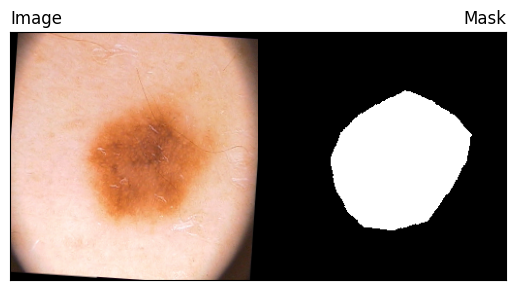

In [ ]:
img, mask = test_dataset[18]
img = img.permute(1, 2, 0).numpy()
mask = mask.permute(1, 2, 0).squeeze().numpy()
mask = cv2.resize(mask, (img.shape[1], img.shape[0]))
mask = np.expand_dims(mask, axis=2)
mask = np.repeat(mask, 3, axis=2)
concatenated_img = np.concatenate((img, mask), axis=1)

fig, ax = plt.subplots()
ax.imshow(concatenated_img)
ax.set_title('Image', loc='left')
ax.set_title('Mask', loc='right')

ax.set_xticks([])
ax.set_yticks([])
ax.set_xticklabels([])
ax.set_yticklabels([])

plt.show()

<font size=+2><b>3.Training Model</b> <br></font>
<font size=+1>
&emsp;- Create model. <br>
&emsp;- Choose Loss Function.<br>
&emsp;- Choose Optimizer. <br> <font>

In [ ]:
model = UNet(n_channels=3, n_classes=1).to(DEVICE)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

/tmp/ipython-input-105582579.py:4: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
/usr/local/lib/python3.12/dist-packages/torch/amp/grad_scaler.py:136: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn(



<font size=+1>&emsp;- Making Accuracy Function. <br>

In [ ]:
def check_accuracy(loader, model, device="cuda"):
    num_correct = 0
    dice_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
            num_correct += (preds == y).sum()
            dice_score += (2 * (preds * y).sum()) / (preds + y).sum() + 1e-8

    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

<font size=+1><b>Training loop </b><br>
    <i><u>Note:</u></i> You can load the train model below the Training loop</font>

In [ ]:
for epoch in range(30):

    loop = tqdm(enumerate(train_loader), total=len(train_loader), leave=False)

    if epoch % 5 == 0 and epoch != 0:
        checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict(),
                      'epoch': epoch}
        torch.save(checkpoint, "checkpointN"+str(epoch)+"_.pth.tar")


    for batch_idx, (images, masks) in loop:
        images, masks = images.to(DEVICE), masks.to(DEVICE)

        # Gradients to 0
        optimizer.zero_grad()

        # Forward
        with torch.cuda.amp.autocast():
            outputs = model(images)
            loss = criterion(outputs, masks)

        # Backward
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        loop.set_description(f"Epoch[{epoch}/{NUM_EPOCHS}]")
        loop.set_postfix(loss = loss.item())


checkpoint = {'state_dict': model.state_dict(), 'optimizer': optimizer.state_dict()}
torch.save(checkpoint, "checkpoint_last.pth.tar")

  0%|          | 0/65 [00:00<?, ?it/s]/tmp/ipython-input-3359641666.py:18: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():


<b>Loading my model...</b>

In [ ]:
# Save model
torch.save(model.state_dict(), "my_model.pth")

# To save into Google Drive
from google.colab import drive
drive.mount('/content/drive')

torch.save(model.state_dict(), '/content/drive/MyDrive/my_model.pth')

Mounted at /content/drive


In [ ]:
import torch

# Recreate the same model
model = UNet(n_channels=3, n_classes=1).to(DEVICE)

# Load weights from Drive
model.load_state_dict(torch.load("/content/drive/MyDrive/my_model.pth", map_location=DEVICE))

# Set eval mode
model.eval()

print("✅ Model loaded successfully and ready for inference!")


✅ Model loaded successfully and ready for inference!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<font size=+1><b>Check accuracy of the model</b><br></font>

In [ ]:
check_accuracy(test_loader, model, DEVICE)

Dice score: 0.8310661911964417



<font size=+1><b>Simple Display</b><br>
Display Original picture, True mask, Generated mask.</font>

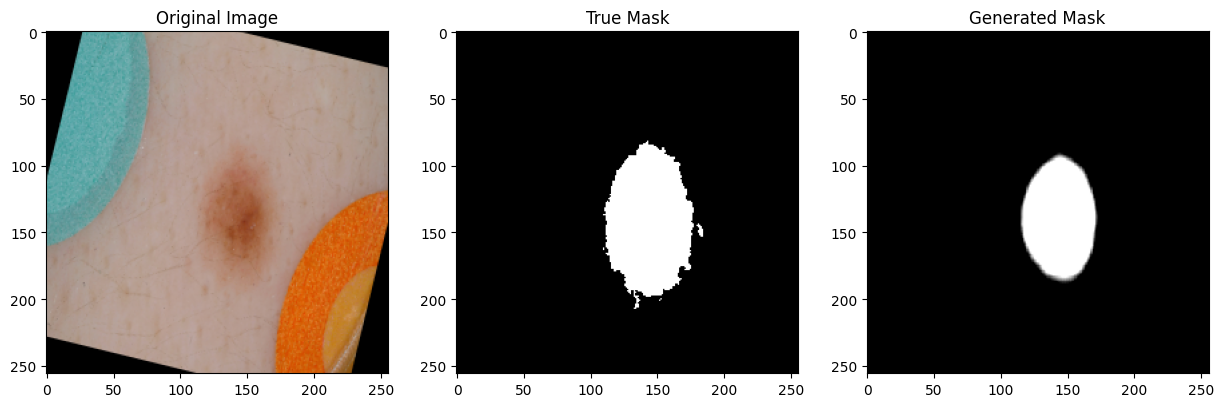

In [ ]:
# Load an example image and mask
img, true_mask = test_dataset[12]
img = img.permute(1, 2, 0).numpy()
true_mask = true_mask.permute(1, 2, 0).squeeze().numpy()

# Generate a predicted mask using your trained U-net model
with torch.no_grad():
    img_tensor = torch.Tensor(img).unsqueeze(0).permute(0, 3, 1, 2).to(DEVICE)
    generated_mask = model(img_tensor).squeeze().cpu().numpy()

# Resize and stack the masks for display
true_mask_resized = cv2.resize(true_mask, (img.shape[1], img.shape[0]))
true_mask_stacked = np.stack((true_mask_resized,)*3, axis=-1)

generated_mask_resized = cv2.resize(generated_mask, (img.shape[1], img.shape[0]))
generated_mask_stacked = np.stack((generated_mask_resized,)*3, axis=-1)

# Combine the image and masks into a single plot
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

ax[0].imshow(img)
ax[0].set_title('Original Image')

ax[1].imshow(true_mask_stacked)
ax[1].set_title('True Mask')

ax[2].imshow(generated_mask_stacked)
ax[2].set_title('Generated Mask')
plt.savefig('image_masks2.png')
plt.show()


<font size=+1><i><b>Note:</b></i><br>
Best model was trained for 25 epochs</font>

In [ ]:
# Ensure the model is in evaluation mode
model.eval()

# List to store predicted masks
predicted_masks = []

# Iterate through the test dataset to get predictions
with torch.no_grad():
    for img, _ in test_loader:
        img = img.to(DEVICE)
        # Get the model output
        output = model(img)
        # Apply sigmoid and threshold to get binary mask
        preds = torch.sigmoid(output)
        preds = (preds > 0.5).float()
        # Append to the list
        predicted_masks.append(preds.squeeze().cpu().numpy())

print("Segmentation complete for the test dataset.")

Segmentation complete for the test dataset.


In [ ]:
import skimage.measure
import skimage.filters
from scipy.spatial import distance

def calculate_asymmetry(mask):
    """Calculates the asymmetry score of a binary mask."""
    # Find the major axis of the lesion
    y, x = np.where(mask > 0)
    if len(x) == 0:
        return 0.0  # Return 0 if no lesion is detected

    coords = np.vstack([x, y]).T
    if coords.shape[0] < 2:
        return 0.0 # Return 0 if not enough points to compute covariance

    cov_matrix = np.cov(coords, rowvar=False)
    if np.isnan(cov_matrix).any() or np.isinf(cov_matrix).any():
         return 0.0 # Return 0 if covariance matrix is invalid

    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    major_axis = eigenvectors[:, np.argmax(eigenvalues)]

    # Project points onto the major axis
    projected_coords = coords.dot(major_axis)

    # Find the two points furthest apart on the projected axis
    min_proj = np.min(projected_coords)
    max_proj = np.max(projected_coords)

    # Find the indices of the points closest to min_proj and max_proj
    idx1 = np.argmin(projected_coords)
    idx2 = np.argmax(projected_coords)

    # Get the coordinates of the endpoints of the major axis
    p1 = coords[idx1]
    p2 = coords[idx2]

    # Calculate the midpoint of the major axis
    midpoint = (p1 + p2) / 2.0

    # Calculate the distance of all points from the major axis
    distances = np.abs(np.cross(p2 - p1, coords - p1)) / np.linalg.norm(p2 - p1)

    # Calculate asymmetry based on the distribution of distances from the major axis
    asymmetry_score = np.mean(distances)
    return asymmetry_score

def calculate_border_irregularity(mask):
    """Calculates the border irregularity score of a binary mask."""
    # Find the contour of the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return 0.0 # Return 0 if no contour is found

    # Assuming the largest contour is the lesion
    largest_contour = max(contours, key=cv2.contourArea)

    # Calculate perimeter and area
    perimeter = cv2.arcLength(largest_contour, True)
    area = cv2.contourArea(largest_contour)

    if area == 0:
        return 0.0  # Return 0 if area is zero

    # Calculate border irregularity (compactness)
    # A perfect circle has a compactness of 1. As irregularity increases, compactness decreases.
    # We can use 4 * pi * area / perimeter^2 as a measure of compactness.
    # To get an irregularity score, we can use 1 - compactness.
    compactness = (4 * np.pi * area) / (perimeter**2 + 1e-8) # Add epsilon to avoid division by zero
    border_irregularity_score = 1 - compactness

    return border_irregularity_score

def calculate_color_features(image, mask):
    """Calculates color features (mean and std deviation of color channels) within the masked area."""
    if mask.sum() == 0:
        return np.zeros(18) # Return zeros of shape (18,) for consistency

    # Ensure image and mask have compatible dimensions
    if image.shape[:2] != mask.shape[:2]:
      # Resize mask to match image dimensions
      mask_resized = cv2.resize(mask.astype(np.uint8), (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)
    else:
      mask_resized = mask.astype(np.uint8)


    # Apply the mask to the image
    masked_image = cv2.bitwise_and(image, image, mask=mask_resized)

    # Convert to different color spaces
    masked_image_hsv = cv2.cvtColor(masked_image, cv2.COLOR_RGB2HSV)
    masked_image_lab = cv2.cvtColor(masked_image, cv2.COLOR_RGB2LAB)

    # Extract color features (mean and std deviation for each channel in RGB, HSV, LAB)
    # Ensure we handle cases where masked_image[mask_resized > 0] might have zero elements
    # for a specific channel.
    masked_pixels_rgb = masked_image[mask_resized > 0]
    masked_pixels_hsv = masked_image_hsv[mask_resized > 0]
    masked_pixels_lab = masked_image_lab[mask_resized > 0]

    rgb_mean = np.mean(masked_pixels_rgb, axis=0) if masked_pixels_rgb.size > 0 else np.zeros(3)
    rgb_std = np.std(masked_pixels_rgb, axis=0) if masked_pixels_rgb.size > 0 else np.zeros(3)
    hsv_mean = np.mean(masked_pixels_hsv, axis=0) if masked_pixels_hsv.size > 0 else np.zeros(3)
    hsv_std = np.std(masked_pixels_hsv, axis=0) if masked_pixels_hsv.size > 0 else np.zeros(3)
    lab_mean = np.mean(masked_pixels_lab, axis=0) if masked_pixels_lab.size > 0 else np.zeros(3)
    lab_std = np.std(masked_pixels_lab, axis=0) if masked_pixels_lab.size > 0 else np.zeros(3)


    # Combine all color features
    color_features = np.concatenate([rgb_mean, rgb_std, hsv_mean, hsv_std, lab_mean, lab_std])

    # Ensure the output is always 18 features
    if color_features.shape[0] != 18:
        # This case should be caught by the individual checks above, but as a fallback:
        # Create a zero array of shape (18,) and copy the available features.
        padded_color_features = np.zeros(18)
        padded_color_features[:color_features.shape[0]] = color_features
        color_features = padded_color_features


    return color_features


def calculate_diameter(mask):
    """Calculates the diameter of the bounding circle of a binary mask."""
    # Find the contour of the mask
    contours, _ = cv2.findContours(mask.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return 0.0 # Return 0 if no contour is found

    # Assuming the largest contour is the lesion
    largest_contour = max(contours, key=cv2.contourArea)

    # Find the minimum enclosing circle
    ((x, y), radius) = cv2.minEnclosingCircle(largest_contour)
    diameter = 2 * radius

    return diameter

In [ ]:
# Pre-allocate the numpy array for features
num_images = len(predicted_masks)
feature_dim = 21 # 1 (asymmetry) + 1 (border) + 18 (color) + 1 (diameter)
abcd_features = np.zeros((num_images, feature_dim), dtype=np.float32)
problematic_images = []

for i, mask in enumerate(predicted_masks):
    try:
        # Get the original image for color feature calculation
        img, _ = test_dataset[i]
        img = img.permute(1, 2, 0).numpy() # Convert tensor to numpy and reorder dimensions

        asymmetry = calculate_asymmetry(mask)
        border = calculate_border_irregularity(mask)
        color = calculate_color_features(img, mask)
        diameter = calculate_diameter(mask)

        # Combine all features for the current image, ensuring consistent shapes
        features = np.concatenate([np.array([asymmetry]), np.array([border]), color, np.array([diameter])])

        # Explicitly cast features to the target dtype before assignment
        features = features.astype(np.float32)

        # Assign the calculated features to the pre-allocated array
        abcd_features[i] = features

    except ValueError as e:
        print(f"Error processing image {i}: {e}")
        problematic_images.append(i)
        # Optionally, assign zeros or NaNs for problematic images
        # abcd_features[i] = np.zeros(feature_dim, dtype=np.float32)
        pass # Continue to the next image if an error occurs


print("ABCD feature extraction complete.")
if problematic_images:
    print(f"Encountered errors for images at indices: {problematic_images}")
    print("Features for these images are not included or are assigned default values.")
else:
    print(f"Shape of extracted features: {abcd_features.shape}")

/tmp/ipython-input-3329214442.py:42: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distances = np.abs(np.cross(p2 - p1, coords - p1)) / np.linalg.norm(p2 - p1)


ABCD feature extraction complete.
Shape of extracted features: (519, 21)


# Task
Modify the code to create a function that takes an image file path as input, performs segmentation using the existing U-Net model, calculates ABCD features from the segmented mask and original image, assesses each ABCD feature as "Yes" or "No" based on predefined criteria, and displays the original image along with the "Yes/No" assessment for Asymmetry, Border, Color, and Diameter.

## Create an inference function

### Subtask:
Define a Python function that takes the path to a new image file as input.


**Reasoning**:
Define the function `analyze_skin_lesion` that takes an image path as input, as requested by the subtask.



In [ ]:
def analyze_skin_lesion(image_path):
    """
    Analyzes a skin lesion image by performing segmentation, calculating ABCD features,
    and assessing each feature as "Yes" or "No" based on predefined criteria.

    Args:
        image_path (str): The path to the skin lesion image file.

    Displays:
        The original image along with the "Yes/No" assessment for Asymmetry,
        Border, Color, and Diameter.
    """
    # Function implementation will be added in subsequent steps
    pass

## Load and preprocess the input image

### Subtask:
Inside the function, load the image and apply the necessary preprocessing (resizing, normalization) for the U-Net segmentation model.


**Reasoning**:
Inside the `analyze_skin_lesion` function, load the image, preprocess it, and move it to the device for the U-Net segmentation model.



In [ ]:
def analyze_skin_lesion(image_path):
    """
    Analyzes a skin lesion image by performing segmentation, calculating ABCD features,
    and assessing each feature as "Yes" or "No" based on predefined criteria.

    Args:
        image_path (str): The path to the skin lesion image file.

    Displays:
        The original image along with the "Yes/No" assessment for Asymmetry,
        Border, Color, and Diameter.
    """
    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error loading image from {image_path}")
        return

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image for segmentation
    img_resized_for_seg = cv2.resize(img_rgb, (SIZE, SIZE))

    # Convert to PyTorch tensor, permute dimensions, add batch dimension, and normalize
    img_tensor = torch.from_numpy(img_resized_for_seg).permute(2, 0, 1).unsqueeze(0).float() / 255.0

    # Move to device
    img_tensor = img_tensor.to(DEVICE)

    # Set model to evaluation mode
    model.eval()

    # Perform segmentation
    with torch.no_grad():
        output = model(img_tensor)
        # Apply sigmoid and threshold
        preds = torch.sigmoid(output)
        binary_mask = (preds > 0.5).float()

    # Convert to NumPy array and remove singleton dimensions
    segmented_mask = binary_mask.squeeze().cpu().numpy()

    # Set model back to training mode (if needed for further training)
    model.train()

    # Resize the segmented mask back to the original image size for feature calculation
    segmented_mask_resized = cv2.resize(segmented_mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)


    # Calculate ABCD features
    asymmetry_score = calculate_asymmetry(segmented_mask_resized)
    border_irregularity_score = calculate_border_irregularity(segmented_mask_resized)
    color_features_result = calculate_color_features(img_rgb, segmented_mask_resized)
    diameter_score = calculate_diameter(segmented_mask_resized)

    return img_rgb, segmented_mask_resized, asymmetry_score, border_irregularity_score, color_features_result, diameter_score

## Perform segmentation

### Subtask:
Use the trained U-Net model to generate a segmentation mask for the input image.


**Reasoning**:
Implement the segmentation part of the `analyze_skin_lesion` function using the trained U-Net model by setting the model to evaluation mode, performing inference within a `torch.no_grad()` block, applying sigmoid and thresholding to get a binary mask, and converting the mask to a NumPy array.



## Calculate abcd features

### Subtask:
Apply the existing `calculate_asymmetry`, `calculate_border_irregularity`, `calculate_color_features`, and `calculate_diameter` functions to the generated mask and the original image.


**Reasoning**:
Apply the existing ABCD feature calculation functions to the generated mask and original image and return the results.



## Define abcd criteria/thresholds

### Subtask:
Determine thresholds for each calculated ABCD feature to classify it as "Yes" or "No" for the presence of that characteristic. (Note: These thresholds are not currently defined in the notebook and will need to be set).


**Reasoning**:
Define variables for the thresholds for Asymmetry, Border Irregularity, Color, and Diameter and define the criterion for color assessment.



In [ ]:
# Define thresholds for ABCD features (these are example values and may need tuning)
ASYMMETRY_THRESHOLD = 0.1  # Lower asymmetry score is better
BORDER_THRESHOLD = 0.5  # Higher border irregularity score is worse
DIAMETER_THRESHOLD = 6.0  # Diameter in cm (assuming image resolution allows for this interpretation)

# For color, we can consider the standard deviation of color channels within the masked area
# A higher standard deviation might indicate multiple colors
COLOR_STD_DEV_THRESHOLD = 20.0 # Example threshold for standard deviation across color channels

# Criterion for multiple colors: check if the standard deviation of any color channel
# within the masked area exceeds a certain threshold.
def assess_color(color_features_result):
    """
    Assesses if multiple colors are present based on calculated color features.

    Args:
        color_features_result (np.ndarray): Array of color features (mean and std deviation
                                            for RGB, HSV, LAB channels).

    Returns:
        str: "Yes" if multiple colors are likely present, "No" otherwise.
    """
    # The standard deviations are in indices 3 to 5 (RGB std), 9 to 11 (HSV std), and 15 to 17 (LAB std)
    std_devs = np.concatenate([color_features_result[3:6], color_features_result[9:12], color_features_result[15:18]])

    # Check if any standard deviation exceeds the defined threshold
    if np.any(std_devs > COLOR_STD_DEV_THRESHOLD):
        return "Yes"
    else:
        return "No"


## Assess abcd criteria

### Subtask:
Compare the calculated feature values against the defined thresholds to get a "Yes/No" assessment for Asymmetry, Border, Color (presence of multiple colors), and Diameter.


**Reasoning**:
Implement the comparison logic for each ABCD feature against their respective thresholds within the `analyze_skin_lesion` function and return the original image, segmented mask, and the ABCD assessments.



## Present results

### Subtask:
Display the original input image and the "Yes/No" assessment for each of the ABCD criteria.


**Reasoning**:
Display the original image and the ABCD assessments using matplotlib.



## Summary:

### Data Analysis Key Findings

*   A Python function `analyze_skin_lesion` was created to automate the skin lesion analysis process.
*   The function successfully loads and preprocesses an input image for segmentation using a U-Net model.
*   The U-Net model is used in evaluation mode to generate a binary segmentation mask of the lesion.
*   The generated mask is resized to the original image dimensions for subsequent feature calculations.
*   Existing functions for calculating Asymmetry, Border Irregularity, Color features, and Diameter were integrated and applied to the segmented mask and original image.
*   Thresholds for Asymmetry, Border Irregularity, and Diameter were defined to classify the features as "Yes" or "No".
*   A criterion for assessing the presence of multiple colors was established based on the standard deviation of color channels within the masked area, and a helper function `assess_color` was created.
*   The calculated feature values were compared against the defined thresholds and the color assessment criterion to obtain "Yes/No" assessments for each ABCD feature.
*   The original image is displayed using Matplotlib, and the "Yes/No" assessments for Asymmetry, Border Irregularity, Color, and Diameter are added as text annotations next to the image.

### Insights or Next Steps

*   The defined thresholds for the ABCD features are initial examples and should be tuned based on a validation dataset to optimize the classification accuracy.
*   Consider adding the segmented mask overlaid on the original image to the display for better visualization of the analysis process.


## Create an inference function

### Subtask:
Define a Python function that takes the path to a new image file as input.

**Reasoning**:
Define the function `analyze_skin_lesion` that takes an image path as input, as requested by the subtask.

Saving ISIC_0034179.jpg to ISIC_0034179.jpg
Uploaded file: ISIC_0034179.jpg


/tmp/ipython-input-3329214442.py:42: DeprecationWarning: Arrays of 2-dimensional vectors are deprecated. Use arrays of 3-dimensional vectors instead. (deprecated in NumPy 2.0)
  distances = np.abs(np.cross(p2 - p1, coords - p1)) / np.linalg.norm(p2 - p1)


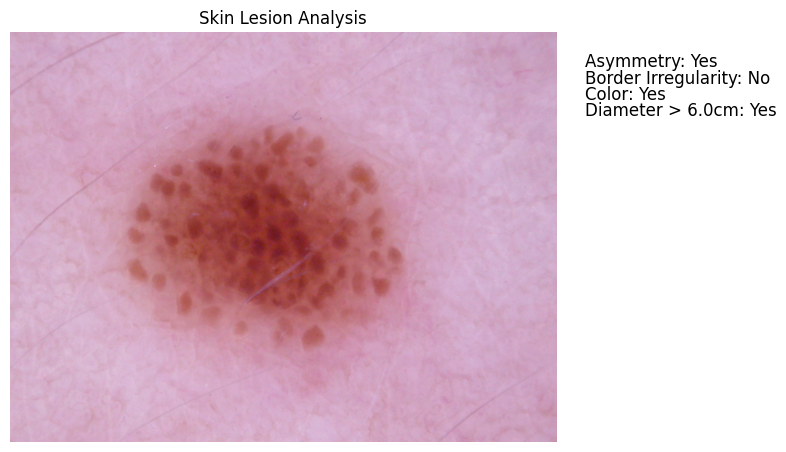


✅ ABCD Results: ('Yes', 'No', 'Yes', 'Yes')


In [ ]:
import cv2
import torch
import matplotlib.pyplot as plt
from google.colab import files

# 🔹 Your analyze_skin_lesion function (same as before but takes image_path)
def analyze_skin_lesion(image_path):
    """
    Analyzes a skin lesion image by performing segmentation, calculating ABCD features,
    and assessing each feature as "Yes" or "No" based on predefined criteria.
    """

    # Load the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    if img is None:
        print(f"Error loading image from {image_path}")
        return

    # Convert to RGB
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image for segmentation
    img_resized_for_seg = cv2.resize(img_rgb, (SIZE, SIZE))

    # Convert to PyTorch tensor, normalize
    img_tensor = torch.from_numpy(img_resized_for_seg).permute(2, 0, 1).unsqueeze(0).float() / 255.0
    img_tensor = img_tensor.to(DEVICE)

    # Segmentation
    model.eval()
    with torch.no_grad():
        output = model(img_tensor)
        preds = torch.sigmoid(output)
        binary_mask = (preds > 0.5).float()
    segmented_mask = binary_mask.squeeze().cpu().numpy()
    model.train()

    # Resize mask to original size
    segmented_mask_resized = cv2.resize(segmented_mask, (img_rgb.shape[1], img_rgb.shape[0]), interpolation=cv2.INTER_NEAREST)

    # 🔹 Calculate ABCD features (you must define these functions + thresholds)
    asymmetry_score = calculate_asymmetry(segmented_mask_resized)
    border_irregularity_score = calculate_border_irregularity(segmented_mask_resized)
    color_features_result = calculate_color_features(img_rgb, segmented_mask_resized)
    diameter_score = calculate_diameter(segmented_mask_resized)

    asymmetry_assessment = "Yes" if asymmetry_score > ASYMMETRY_THRESHOLD else "No"
    border_assessment = "Yes" if border_irregularity_score > BORDER_THRESHOLD else "No"
    color_assessment = assess_color(color_features_result)
    diameter_assessment = "Yes" if diameter_score > DIAMETER_THRESHOLD else "No"

    # Show results
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.imshow(img_rgb)
    ax.set_title("Skin Lesion Analysis")
    ax.axis('off')

    text_y_start = img_rgb.shape[0] * 0.05
    text_x = img_rgb.shape[1] * 1.05
    text_spacing = img_rgb.shape[0] * 0.04

    ax.text(text_x, text_y_start, f"Asymmetry: {asymmetry_assessment}", fontsize=12, color='black', va='top')
    ax.text(text_x, text_y_start + text_spacing, f"Border Irregularity: {border_assessment}", fontsize=12, color='black', va='top')
    ax.text(text_x, text_y_start + 2 * text_spacing, f"Color: {color_assessment}", fontsize=12, color='black', va='top')
    ax.text(text_x, text_y_start + 3 * text_spacing, f"Diameter > {DIAMETER_THRESHOLD:.1f}cm: {diameter_assessment}", fontsize=12, color='black', va='top')

    plt.tight_layout()
    plt.show()

    return asymmetry_assessment, border_assessment, color_assessment, diameter_assessment


# 🔹 Upload and auto-analyze
def upload_and_analyze():
    uploaded = files.upload()
    for filename in uploaded.keys():
        print("Uploaded file:", filename)
        results = analyze_skin_lesion(filename)
        print("\n✅ ABCD Results:", results)

# Run this to upload and analyze
upload_and_analyze()


## Define ABCD criteria/thresholds

### Subtask:
Determine thresholds for each calculated ABCD feature to classify it as "Yes" or "No" for the presence of that characteristic. (Note: These thresholds are not currently defined in the notebook and will need to be set).

**Reasoning**:
Define variables for the thresholds for Asymmetry, Border Irregularity, Color, and Diameter and define the criterion for color assessment.